In [ ]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load the dataset
file_path = r"C:\Users\91950\Downloads\medical_cost_insurance (1)\medical_cost_insurance\medc.csv"
df = pd.read_csv(file_path)

In [ ]:
# View the dataset
print("Dataset Head:")
print(df.head())

Dataset Head:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [ ]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())
#No missing values found


Missing Values:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


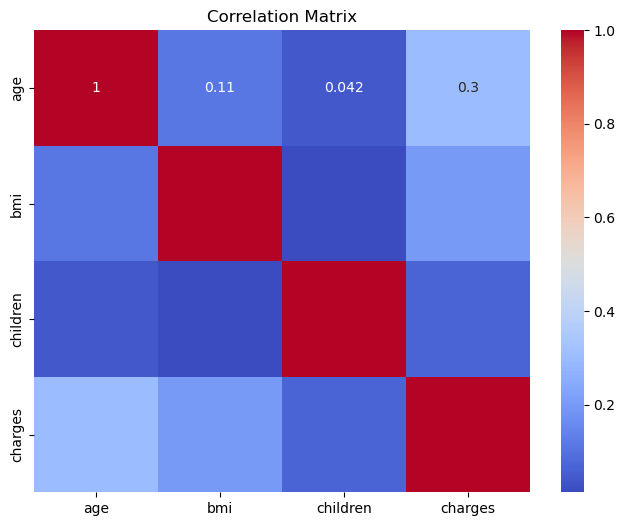

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


In [ ]:
# Print the numerical correlation matrix
correlation_matrix = df.corr(numeric_only=True)
print("Correlation Matrix:")
print(correlation_matrix)


Correlation Matrix:
               age       bmi  children   charges
age       1.000000  0.109272  0.042469  0.299008
bmi       0.109272  1.000000  0.012759  0.198341
children  0.042469  0.012759  1.000000  0.067998
charges   0.299008  0.198341  0.067998  1.000000


In [ ]:
# Convert categorical variables to dummy variables
df = pd.get_dummies(df, columns=["sex", "smoker", "region"], drop_first=True)

In [ ]:
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


In [ ]:
# Standardize numerical features
scaler = StandardScaler()
numerical_features = ["age", "bmi", "children"]
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [ ]:
# Split features and target
X = df.drop("charges", axis=1)
y = df["charges"]

In [ ]:
# Select top 2 features based on f_regression
select_k = SelectKBest(score_func=f_regression, k=2)
X_new = select_k.fit_transform(X, y)

In [ ]:
# Get selected feature names
selected_features = X.columns[select_k.get_support()]
print("Selected Features:", list(selected_features))

Selected Features: ['age', 'smoker_yes']


In [ ]:
# Update X with selected features
X = X[selected_features]

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Model Training and Cross-Validation
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
}

In [ ]:
# Cross-Validation
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="r2")
    print(f"{name} Cross-Validation R² Scores: {scores}")
    print(f"{name} Mean R²: {scores.mean():.4f}")

Linear Regression Cross-Validation R² Scores: [0.69927055 0.76958737 0.71196341 0.62431787 0.73192859]
Linear Regression Mean R²: 0.7074
Decision Tree Cross-Validation R² Scores: [0.65711596 0.74818173 0.47517495 0.57209708 0.62659751]
Decision Tree Mean R²: 0.6158
Random Forest Cross-Validation R² Scores: [0.65909384 0.76962601 0.56302317 0.5899481  0.64556156]
Random Forest Mean R²: 0.6455


In [ ]:
# Hyperparameter Tuning
# GridSearch for Decision Tree
dt_params = {"max_depth": [2, 4, 6, 8, 10], "min_samples_split": [2, 5, 10]}
grid_dt = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_params, cv=5, scoring="r2")
grid_dt.fit(X_train, y_train)
print("\nBest Decision Tree Parameters:", grid_dt.best_params_)

# GridSearch for Random Forest
rf_params = {"n_estimators": [50, 100, 150], "max_depth": [4, 6, 8], "min_samples_split": [2, 5]}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring="r2")
grid_rf.fit(X_train, y_train)
print("Best Random Forest Parameters:", grid_rf.best_params_)


Best Decision Tree Parameters: {'max_depth': 4, 'min_samples_split': 2}
Best Random Forest Parameters: {'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 150}


In [ ]:
# Model Evaluation
def evaluate_model(y_test, y_pred, model_name):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"\n{model_name} Performance:")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R² Score: {r2:.4f}")

In [ ]:
final_models = {
    "Linear Regression": models["Linear Regression"],
    "Decision Tree": grid_dt.best_estimator_,
    "Random Forest": grid_rf.best_estimator_,
}


In [ ]:
for name, model in final_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    evaluate_model(y_test, y_pred, name)


Linear Regression Performance:
Mean Absolute Error (MAE): 3990.98
Mean Squared Error (MSE): 38274699.68
R² Score: 0.7535

Decision Tree Performance:
Mean Absolute Error (MAE): 4019.62
Mean Squared Error (MSE): 38316556.38
R² Score: 0.7532

Random Forest Performance:
Mean Absolute Error (MAE): 4037.13
Mean Squared Error (MSE): 38817890.98
R² Score: 0.7500


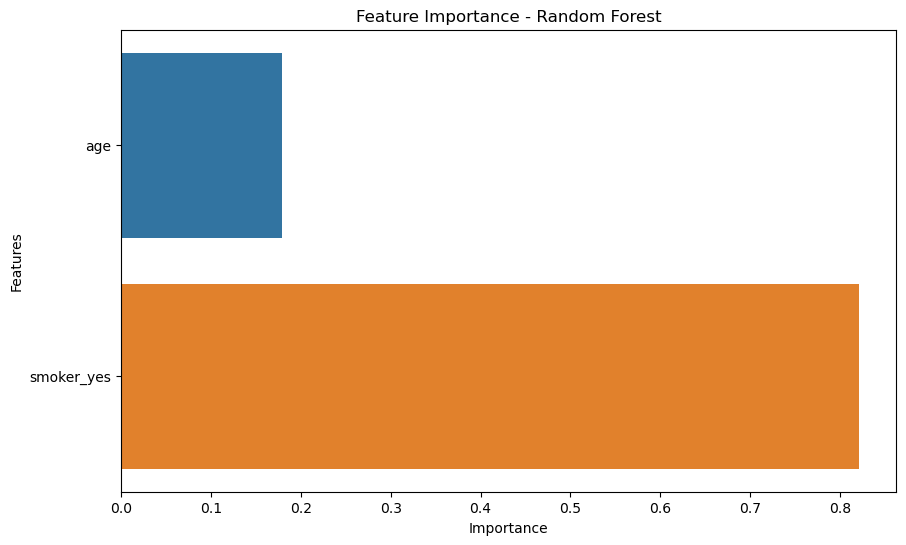

In [ ]:
if "Random Forest" in final_models:
    feature_importance = final_models["Random Forest"].feature_importances_
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importance, y=selected_features)
    plt.title("Feature Importance - Random Forest")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

C:\Users\91950\AppData\Local\Temp/ipykernel_16352/1441420336.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2, color="red")


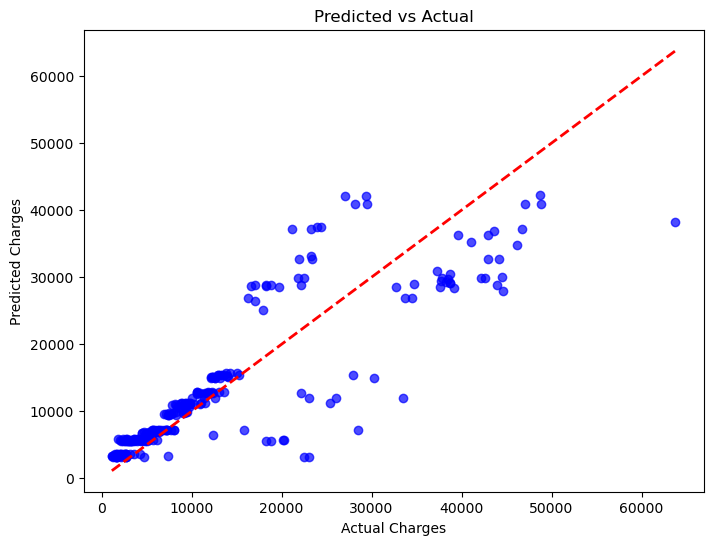

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, final_models["Random Forest"].predict(X_test), alpha=0.7, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2, color="red")
plt.title("Predicted vs Actual")
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.show()